In [17]:
%matplotlib inline

# dependence: `astropy`, `healpy`

In [18]:
import numpy as np
import healpy as hp
import astropy.constants as c
import astropy.units as u
import os,re

In [19]:
def get_joffset(domain):
    '''
        Calculate y offset due to shear
        vy0 = -q*Omega*Lx
        yshear = vy0*dt
        joffset = |yshear/Ly|
    '''
    Lx=domain['xmax']-domain['xmin']
    Ly=domain['ymax']-domain['ymin']
    qomL=qshear*Omega*Lx
    yshear=qomL*domain['time']
    deltay=np.mod(yshear,Ly)
    joffset=deltay/domain['dy']

    return joffset

def get_hat(nside,ipix):
    '''
        Obtain unit vector on the spherical coordinate
    '''

    theta,phi = hp.pix2ang(nside,ipix)
    rhat=[np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]
    thhat=[np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)]
    phhat=[-np.sin(phi),np.cos(phi),0]
    hat={'Z':rhat,'X':thhat,'Y':phhat}

    return hat

def cc_idx(le,dx,pos):
    '''
        Get cell-centered indices for the given 3D position
    '''
    if np.array(pos).ndim == 2:
        le=le[:,np.newaxis]
        dx=dx[:,np.newaxis]
    elif np.array(pos).ndim == 3:
        le=le[:,np.newaxis,np.newaxis]
        dx=dx[:,np.newaxis,np.newaxis]

    idx=(pos-le-0.5*dx)/dx
    return idx

def los_idx_all(hat,domain,smin=0.,smax=3000.,ds=1.,center=[0,0,0],zmax_cut=True):
    '''
        Get corresponding cell-centered indices in the original Cartesian domain of all LOSs
        No BCs applied yet
    '''
    zmax=domain['zmax']
    zmin=domain['zmin']
    xhat=hat[0][:,np.newaxis]
    yhat=hat[1][:,np.newaxis]
    zhat=hat[2][:,np.newaxis]

    sarr=np.arange(smin,smax,ds)
    xarr=xhat*sarr + center[0]
    yarr=yhat*sarr + center[1]
    zarr=zhat*sarr + center[2]

    le=np.array([domain['xmin'],domain['ymin'],domain['zmin']])
    dx=np.array([domain['dx'],domain['dy'],domain['dz']])
    if np.abs(le[2]) < smax: le[2]=-smax
    iarr = cc_idx(le,dx,[xarr,yarr,zarr])

    return iarr,[xarr,yarr,zarr],sarr

def get_index_all(domain,Nside,center,smax,ds,shear=True):
    '''
        Get corresponding cell-centered indices in the original Cartesian domain of all LOSs
        Applying shearing-periodic BCs if necessary
        Return both integer indices and floating point residuals for interpolation as well as 
            background shear velocity (if necessary)
    '''

    npix=hp.nside2npix(Nside)
    ipix=np.arange(npix)
    hat=get_hat(Nside,ipix)
    iarr,xarr,sarr=los_idx_all(hat['Z'],domain,smin=0,smax=smax,ds=ds,center=center)

    Nx=domain['Nx']
    Ny=domain['Ny']
    xdiv,xidx=np.divmod(iarr[0],Nx) # this is for periodic BCs
    if shear: # this is for shearing-periodic BCs
        joffset=get_joffset(domain)
        yidx=np.remainder(iarr[1]+xdiv*joffset,Ny)
    else:
        yidx=np.remainder(iarr[1],Ny) # this is for periodic BCs
        vy0 = None
    zidx=iarr[2]

    x0 = xidx.astype(np.intp)
    y0 = yidx.astype(np.intp)
    z0 = zidx.astype(np.intp)
    dx = xidx - x0
    dy = yidx - y0
    dz = zidx - z0

    return x0,y0,z0,dx,dy,dz

def extend_data(domain,data,smax,shear=True):
    '''
        Copy YZ and XZ slices at i=0 and j=0 to i=Nx and j=Ny, respectively.
        Applying corresponding BCs
    '''
    dslicey=data[:,0,:]
    newdata=np.concatenate((data,dslicey[:,np.newaxis,:]),axis=1) # this is for periodic BCs in y-dir

    if shear: # this is for shearing-periodic BCs in x-dir
        joffset=get_joffset(domain)
        d1=np.roll(newdata[:,:,0],-joffset.astype(np.int),axis=1)
        d2=np.roll(newdata[:,:,0],-(joffset.astype(np.int)+1),axis=1)
        dj=joffset-joffset.astype(np.int)
        dslicex=d1*(1-dj)+d2*dj
    else: # this is for periodic BCs in x-dir
        dslicey=data[:,:,0]

    newdata=np.concatenate((newdata,dslicex[:,:,np.newaxis]),axis=2)

    Nz, Ny, Nx = newdata.shape
    New_Nz=smax/domain['dz']

    if New_Nz>(Nz/2):
        zeros=np.zeros((int(New_Nz-Nz/2),Ny,Nx))
        newdata=np.concatenate((zeros,newdata,zeros),axis=0)
    return newdata

def los_proj(data,domain,deltas,smax,Nside=4,center=[0,0,0]):
    '''
        Get and save trilinear interpolated data field along all LOSs (healpix angle, los distance)
        using 3D array
    ''' 
    x0,y0,z0,dx,dy,dz = get_index_all(domain,Nside,center,smax,deltas)

    data=extend_data(domain,data,smax)
    dlos=data[z0  ,y0  ,x0  ]*(1-dz)*(1-dy)*(1-dx) +\
        data[z0+1,y0  ,x0  ]*dz*(1-dy)*(1-dx) +\
        data[z0  ,y0+1,x0  ]*(1-dz)*dy*(1-dx) +\
        data[z0  ,y0  ,x0+1]*(1-dz)*(1-dy)*dx +\
        data[z0+1,y0+1,x0  ]*dz*dy*(1-dx) +\
        data[z0+1,y0  ,x0+1]*dz*(1-dy)*dx +\
        data[z0  ,y0+1,x0+1]*(1-dz)*dy*dx +\
        data[z0+1,y0+1,x0+1]*dz*dy*dx
 
    return dlos

def vec_proj(vec,domain,deltas,smax,Nside=4,center=[0,0,0]):
    '''
        Get and save trilinear interpolated data field along all LOSs (healpix angle, los distance)
        using 3D array
    ''' 
    v1=los_proj(vec[0],domain,deltas,smax,Nside=Nside,center=[0,0,0])
    v2=los_proj(vec[1],domain,deltas,smax,Nside=Nside,center=[0,0,0])
    v3=los_proj(vec[2],domain,deltas,smax,Nside=Nside,center=[0,0,0])
    npix=hp.nside2npix(Nside)
    ipix = np.arange(npix)
    hat=get_hat(Nside,ipix)
    v_para=hat['Z'][0][:,np.newaxis]*v1+hat['Z'][1][:,np.newaxis]*v2+hat['Z'][2][:,np.newaxis]*v3
    v_perp_x=hat['X'][0][:,np.newaxis]*v1+hat['X'][1][:,np.newaxis]*v2+hat['X'][2][:,np.newaxis]*v3
    v_perp_y=hat['Y'][0][:,np.newaxis]*v1+hat['Y'][1][:,np.newaxis]*v2 #+hat['Y'][2]*v3 -- this is zero
    return v_para,v_perp_x,v_perp_y


# Data and some notes
* Data cube is located at http://tigress-web.princeton.edu/~changgoo/maps-full/R8_4pc/R8_4pc_newacc.0300.ne-B.fits
* The `fits` file contains ne and B vector in the Cartesian coordinate (full original domain in the horizontal direction and +-1024 pc cut-out in the vertical direction)
* `ne` is stored in the cgs units, but `B` in the micro Gauss unit can be obtained by multiplying 0.5476852239548456 to the code value
* `los_proj()` returns a quantity that is projected onto a spherical coordinate centered at an observer
* `vec_proj()` applies `lod_proj` to each vector component and then returns los compoent (parallel) and plane-of-sky components (perp_x and perp_y)
* return array is 2D, consisting of (`healpix_index`, `los_index`)
* For the all-sky pixelization, we use `HEALPix`. For more information, please see
  * you need `healpy` https://healpy.readthedocs.io/en/latest/
  * https://astropy-healpix.readthedocs.io/en/latest/
  * see also `reproject` (https://reproject.readthedocs.io/en/stable/healpix.html)
  * see Section 2.2 of my paper for more details on projection http://adsabs.harvard.edu/abs/2019arXiv190107079K
* If observer's position is off-centered, we need to apply boundary conditions even with the maximum path length of 500pc (see functions above). One can set the maximum path length arbitrarily large (`smax`), but I recommend to use up to 1kpc

### Reading data from fits file

In [20]:
from astropy.io import fits

In [21]:
# you have to change the file name
hdul=fits.open('/tigress/changgoo/R8_4pc_newacc/fits/R8_4pc_newacc.0300.ne-B.fits')

In [22]:
hdul.info()

Filename: /tigress/changgoo/R8_4pc_newacc/fits/R8_4pc_newacc.0300.ne-B.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  NE            1 ImageHDU        24   (256, 256, 512)   float32   
  2  BX            1 ImageHDU        24   (256, 256, 512)   float32   
  3  BY            1 ImageHDU        24   (256, 256, 512)   float32   
  4  BZ            1 ImageHDU        24   (256, 256, 512)   float32   


In [23]:
hdr=hdul[0].header

In [24]:
hdr['Nx']=hdul[1].header['Naxis1']
hdr['Ny']=hdul[1].header['Naxis2']
hdr['Nz']=hdul[1].header['Naxis3']

In [25]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TIME    =             300.0002                                                  
XMIN    =               -512.0 / pc                                             
XMAX    =                512.0 / pc                                             
YMIN    =               -512.0 / pc                                             
YMAX    =                512.0 / pc                                             
ZMIN    =              -1024.0 / pc                                             
ZMAX    =               1024.0 / pc                                             
DX      =                  4.0 / pc                                             
DY      =                  4

In [33]:
ne=hdul[1].data
Bx=hdul[2].data
By=hdul[3].data
Bz=hdul[4].data

### Projecting onto a spherical coordinate centerd on an observer

In [34]:
# global parameters for spherical projection
Nside=128      # Nside for Healpix -- adjustable; this has to be 2^n; total number of pixels is 12*Nside**2
center=[0,0,0] # observer's position -- adjustable; -512<x,y<512; z=0 is the midplane
smax=500       # maximum LOS distance -- adjuatable; smax<=1000 is recommended
Omega=0.028    # galactic rotation km/s/pc -- don't change!
qshear=1.0     # shear parameter: 1 for flat rotation -- don't change!

deltas=hdr['dx'] # ds; can be smaller than the resolution of the simulation, but not so meaningful

In [35]:
# this step is time consuming. it will take longer if you increase Nside and smax or decrease deltas
ne_proj=los_proj(ne,hdr,deltas,smax,Nside=Nside,center=center)
Bpara,Bperp_x,Bperp_y=vec_proj([Bx,By,Bz],hdr,deltas,smax,Nside=Nside,center=center)

In [37]:
import matplotlib.pyplot as plt

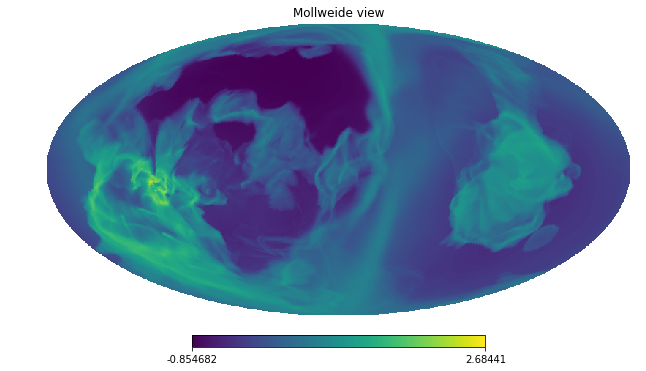

In [38]:
hp.mollview(np.log10(ne_proj.sum(axis=1)))

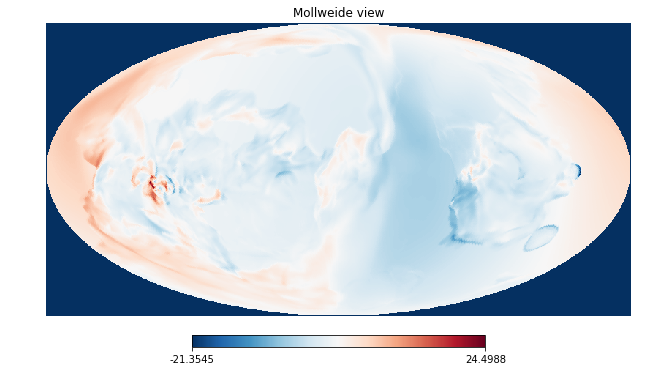

In [39]:
hp.mollview((ne_proj*Bpara).sum(axis=1)/ne_proj.sum(axis=1),cmap=plt.cm.RdBu_r)